# Libraries and set up

Importing necessary libraries:

In [ ]:
import pandas as pd
import numpy as np
import os
from keras import backend as K
from keras.preprocessing.image import load_img, save_img, img_to_array
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras import optimizers
from scipy.optimize import fmin_l_bfgs_b
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

TensorFlow is already loaded. Please restart the runtime to change versions.


Define content and style image path:

In [ ]:
content = 'images/content/'
style = 'images/style/'

Define the exact content image and the style image respectively for this project:

In [ ]:
content_path = content + 'photo0.jpg'
style_path = style + 'Pablo_Picasso_92.jpg'

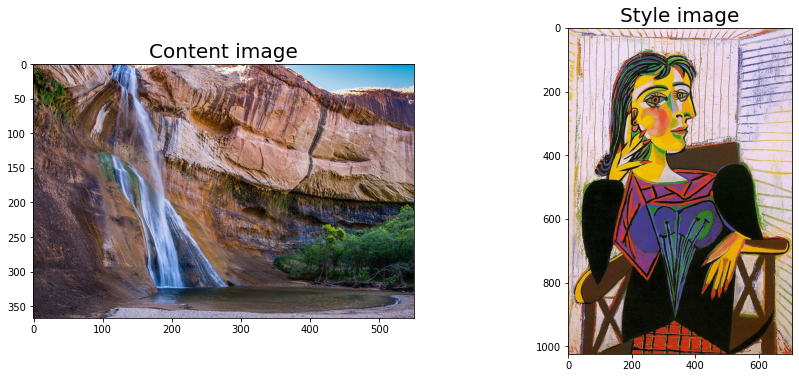

In [ ]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.title('Content image',fontsize=20)
content_img = plt.imread(content_path)
plt.imshow(content_img)
plt.subplot(1,2,2)
plt.title('Style image',fontsize=20)
style_img = plt.imread(style_path)
plt.imshow(style_img)

Dimensions of image:

In [ ]:
width, height = load_img(content_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

# Preprocessing the image 

Preprocessing is done with the help of the pretrained model VGG19. VGG19 is a model, with weights pre-trained on ImageNet. ImageNet, is a dataset of over 15 millions labeled high-resolution images with around 22,000 categories.

In [ ]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [ ]:
# Get tensor representations of our images
content_image = K.variable(preprocess_image(content_path))
style_image = K.variable(preprocess_image(style_path))

In [ ]:
K.image_data_format()

'channels_last'

This will contain our generated image. Variable in tensorflow is as any other variable - we initialize it, we can modify it, etc. Whereas placeholder doesn't require initial value. Placeholder simply allocates block of memory for future use. Later, we can use feed_dict to feed the data into placeholder. By default, placeholder has an unconstrained shape, which allows you to feed tensors of different shapes in a session.

In [ ]:
# This will contain our generated image
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1,3,img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1,img_nrows, img_ncols,3))

In [ ]:
# Combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([content_image,
                              style_image,
                              combination_image],
                              axis=0)

In [ ]:
# Build the VGG19 network with our 3 images as input
# Model will be loaded with pre-trained ImageNet weights
model = VGG19(input_tensor=input_tensor,
              include_top = False,
              weights='imagenet')
print('Model loaded.')

Model loaded.


VGG19 model is used for classification, and since our goal is not to classify but rather to transform an image, we are excluding those layers which are used for classification.

In [ ]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1',
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
print(outputs_dict['block5_conv2'])

Tensor("block5_conv2/Relu:0", shape=(3, 25, 37, 512), dtype=float32)


#### The content loss

Given a chosen content layer l, the content loss is defined as the Mean Squared Error between the feature map F of our content image C and the feature map P of our generated image Y

In [ ]:
# An auxiliary loss function designed to maintain the "content" 
# of the base image in the generated image
def get_content_loss(content, target):
    return K.sum(K.square(target - content))

#### The style loss

To do this at first we need to, calculate the  Gram-matrix (a matrix comprising of correlated features) for the tensors output by the style-layers. The Gram-matrix is essentially just a matrix of dot-products for the vectors of the feature activations of a style-layer.

If an entry in the Gram-matrix has a value close to zero then it means the two features in the given layer do not activate simultaneously for the given style-image. And vice versa, if an entry in the Gram-matrix has a large value, then it means the two features do activate simultaneously for the given style-image. We will then try and create a mixed-image that replicates this activation pattern of the style-image.

The loss function for style is quite similar to out content loss, except that we calculate the Mean Squared Error for the Gram-matrices instead of the raw tensor-outputs from the layers.

In [ ]:
import tensorflow as tf
# Gram-matrix of an image tensor (feature-wise outer product)
def gram_matrix(input_tensor):
    assert K.ndim(input_tensor)==3
    #if K.image_data_format() == 'channels_first':
    #    features = K.batch_flatten(input_tensor)
    #else:
    #    features = K.batch_flatten(K.permute_dimensions(input_tensor,(2,0,1)))
    #gram = K.dot(features, K.transpose(features))
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram#/tf.cast(n, tf.float32)

def get_style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows*img_ncols
    return K.sum(K.square(S-C))#/(4.0 * (channels ** 2) * (size ** 2))
    

In [ ]:
content_weight=0.025 
style_weight=1.0
# combine these loss functions into a single scalar
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
print('Layer Feature for Content Layers :: '+str(layer_features))
print('Base Image Feature :: '+str(content_image_features))
print('Combination Image Feature for Content Layers:: '+str(combination_features)+'\n')
loss = loss + (content_weight * get_content_loss(content_image_features,
                                      combination_features))

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    print('Layer Feature for Style Layers :: '+str(layer_features))
    print('Style Image Feature :: '+str(style_reference_features))
    print('Combination Image Feature for Style Layers:: '+str(combination_features)+'\n')
    sl = get_style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

Layer Feature for Content Layers :: Tensor("block5_conv2/Relu:0", shape=(3, 25, 37, 512), dtype=float32)
Base Image Feature :: Tensor("strided_slice:0", shape=(25, 37, 512), dtype=float32)
Combination Image Feature for Content Layers:: Tensor("strided_slice_1:0", shape=(25, 37, 512), dtype=float32)

Layer Feature for Style Layers :: Tensor("block1_conv1/Relu:0", shape=(3, 400, 599, 64), dtype=float32)
Style Image Feature :: Tensor("strided_slice_2:0", shape=(400, 599, 64), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_3:0", shape=(400, 599, 64), dtype=float32)

Layer Feature for Style Layers :: Tensor("block2_conv1/Relu:0", shape=(3, 200, 299, 128), dtype=float32)
Style Image Feature :: Tensor("strided_slice_6:0", shape=(200, 299, 128), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_7:0", shape=(200, 299, 128), dtype=float32)

Layer Feature for Style Layers :: Tensor("block3_conv1/Relu:0", shape=(3, 100, 149, 256), 

Features are extracted from each layer in style layers and content layers and their overall loss is calculated from it.

This deprocess_image function is used to return the original format of the final image after transformation which could be easily read and displayed by matplotlib.

In [ ]:
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Calculation of gradient with respect to loss:

In [ ]:
# Get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)
grads

[<tf.Tensor 'gradients/concat_grad/Slice_2:0' shape=(1, 400, 599, 3) dtype=float32>]

In [ ]:
outputs = [loss]
if isinstance(grads, (list,tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = K.function([combination_image], outputs)
f_outputs

Athough there are various optimizers, we have used L-BFGS optimizer in this case. Another option is Adam optimizer.

In [ ]:
# Run scipy-based optimization (L-BFGS) over the pixels of the generated image
# to minimize the neural style loss
x_opt = preprocess_image(content_path)

In [ ]:
def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

The purpose of this Evaluator class is to avoid the error 'numpy.ndarray' object is not callable with optimize.minimize while running the L-BFGS optimizer for loss minimization.

In [ ]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [ ]:
evaluator = Evaluator()

In this segment we run the code up to a given iteration. Although I would not recommend to use maxiter parameter in fmin_l_bfgs_b to set the number of iterations. Rarther use iteration in for loop to get better results.

In [ ]:
iterations=400
# Store our best result
best_loss, best_img = float('inf'), None
for i in range(iterations):
    print('Start of iteration', i)
    x_opt, min_val, info= fmin_l_bfgs_b(evaluator.loss, 
                                        x_opt.flatten(), 
                                        fprime=evaluator.grads,
                                        maxfun=20,
                                        disp=True,
                                       )
    print('Current loss value:', min_val)
    if min_val < best_loss:
        # Update best loss and best image from total loss. 
        best_loss = min_val
        best_img = x_opt.copy()

The Final Image


In [ ]:
# save current generated image
imgx = deprocess_image(best_img.copy())
plt.imshow(imgx)

NameError: ignored

In [ ]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.title("Base Image",fontsize=20)
img_base = load_img(content_path)
plt.imshow(img_base)

plt.subplot(5,5,1+1)
plt.title("Style Image",fontsize=20)
img_style = load_img(style_path)
plt.imshow(img_style)

plt.subplot(5,5,1+2)
plt.title("Final Image",fontsize=20)
plt.imshow(imgx)

This function Run_Style_Transfer is nothing but combination of all the above code that is discussed in the above cells part by part. It returns the final image after style transfer between two images.

In [ ]:
def preprocess_image_instantiator(image_path,img_nrows,img_ncols):
    from keras.applications import vgg19
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [ ]:
from tensorflow.python.ops.gen_math_ops import imag
def Run_StyleTransfer(content_path, style_path):
    
    width, height = load_img(content_path).size
    img_nrows = 400
    img_ncols = int(width * img_nrows / height)
    
    content_image = K.variable(preprocess_image_instantiator(content_path,img_nrows,img_ncols))
    style_reference_image = K.variable(preprocess_image_instantiator(style_path,img_nrows,img_ncols))
    
    if K.image_data_format() == 'channels_first':
        combination_image = K.placeholder((1,3,img_nrows, img_ncols))
    else:
        combination_image = K.placeholder((1,img_nrows, img_ncols,3))
        
    input_tensor = K.concatenate([content_image,
                                  style_reference_image,
                                  combination_image
                                  ], axis=0)
    from keras.applications.vgg19 import VGG19
    #vgg19_weights = 'vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
    model = VGG19(input_tensor=input_tensor,
                  include_top = False,
                  weights='imagenet'
                  )
    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
    
    content_weight=0.025 
    style_weight=1.0
    # combine these loss functions into a single scalar
    loss = K.variable(0.0)
    layer_features = outputs_dict['block5_conv2']
    content_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    #print('Layer Feature for Content Layers :: '+str(layer_features))
    #print('Base Image Feature :: '+str(base_image_features))
    #print('Combination Image Feature for Content Layers:: '+str(combination_image_features))
    loss = loss + content_weight * get_content_loss(content_image_features,
                                          combination_features)

    feature_layers = ['block1_conv1', 'block2_conv1',
                      'block3_conv1', 'block4_conv1',
                      'block5_conv1']
    for layer_name in feature_layers:
        layer_features = outputs_dict[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        #print('Layer Feature for Style Layers :: '+str(layer_features))
        #print('Style Image Feature :: '+str(style_reference_features))
        #print('Combination Image Feature for Style Layers:: '+str(combination_features))
        sl = get_style_loss(style_reference_features, combination_features)
        loss = loss + (style_weight / len(feature_layers)) * sl
        
    grads = K.gradients(loss, combination_image)
    
    outputs = [loss]
    if isinstance(grads, (list,tuple)):
        outputs += grads
    else:
        outputs.append(grads)
    f_outputs = K.function([combination_image], outputs)
    
    x_opt = preprocess_image(content_path)
    
    evaluator = Evaluator()
    iterations=150
    # Store our best result
    best_loss, best_img = float('inf'), None
    for i in range(iterations):
        #print('Start of iteration', i)
        x_opt, min_val, info= fmin_l_bfgs_b(evaluator.loss, 
                                            x_opt.flatten(), 
                                            fprime=evaluator.grads,
                                            maxfun=20,
                                            disp=True,
                                           )
        #print('Current loss value:', min_val)
        if min_val < best_loss:
            # Update best loss and best image from total loss. 
            best_loss = min_val
            best_img = x_opt.copy()
    imgx = deprocess_image(best_img.copy())
    
    return imgx

In [ ]:
content_path_1 = content_path
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.title("Content Image",fontsize=20)
img_content = load_img(content_path_1)
plt.imshow(img_content)

style_path_1 = style_path
plt.subplot(5,5,1+1)
plt.title("Style Image",fontsize=20)
img_style = load_img(style_path_1)
plt.imshow(img_style)

plt.subplot(5,5,1+2)
imgg = Run_StyleTransfer(content_path_1, style_path_1)
plt.title("Final Image",fontsize=20)
plt.imshow(imgg)